In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.impute import SimpleImputer
import scipy as scp

from copy import deepcopy
from natsort import natsorted

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 25, 5

In [2]:
sleep_scoring_df = pd.DataFrame()

pkl_filez = natsorted(glob.glob('/media/HlabShare/james/LFP_and_motion_pkls/*.pkl'))
for pklfile in pkl_filez:
    tmpdf = []
    tmpdf = pd.read_pickle(pklfile)

    sleep_scoring_df = pd.concat([sleep_scoring_df, tmpdf])

In [3]:
sleep_scoring_df.query('AnimalName == "CAF79"').Date.unique()

array([], dtype=object)

In [4]:
sleep_scoring_df.AnimalName.unique()

array(['CAF22', 'CAF34', 'CAF37', 'CAF40', 'CAF49', 'CAF52', 'CAF60',
       'CAF69', 'CAF78', 'CAF81', 'CAF84', 'CAF88', 'CAF89', 'CAF95',
       'CAF100', 'CAF101', 'CAF102', 'KDR14', 'KDR27', 'KDR36', 'kdr48'],
      dtype=object)

In [10]:
file = sleep_scoring_df.query('AnimalName == "CAF37"').sleep_labels.to_numpy()
np.save('/media/HlabShare/Sleep_Scoring/CAF00037/caf3708272020/CAF00037_SleepStates.npy', file)

## Smoothing

In [11]:
(sleep_scoring_df[sleep_scoring_df.AnimalName == 'CAF37'].sleep_labels == 3).mean() * 3600 * 24

76.0

In [5]:
# Extract features and sleep labels from dataframe
delta = sleep_scoring_df['delta'].to_numpy()
theta = sleep_scoring_df['theta'].to_numpy()
alpha = sleep_scoring_df['alpha'].to_numpy()
beta = sleep_scoring_df['beta'].to_numpy()
sigma = sleep_scoring_df['sigma'].to_numpy()
motion = sleep_scoring_df['motion'].to_numpy()
gamma = sleep_scoring_df['gamma'].to_numpy()
thetaratio = sleep_scoring_df['thetaratio'].to_numpy()

y = sleep_scoring_df['sleep_labels'].to_numpy()

# Assuming delta is a NumPy array
window_size = 10  # Adjust as desired

# Compute rolling mean using convolution
#motion_rolling_mean = np.convolve(np.pad(sleep_scoring_df['motion'].to_numpy(), (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
delta_rolling_mean = np.convolve(np.pad(delta, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
theta_rolling_mean = np.convolve(np.pad(theta, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
alpha_rolling_mean = np.convolve(np.pad(alpha, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
beta_rolling_mean = np.convolve(np.pad(beta, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
gamma_rolling_mean = np.convolve(np.pad(gamma, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
sigma_rolling_mean = np.convolve(np.pad(sigma, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
thetaratio_rolling_mean = np.convolve(np.pad(thetaratio, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
motion_rolling_mean = np.convolve(np.pad(motion, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')

In [6]:
df_RM = pd.DataFrame(
    {
        'delta' : delta_rolling_mean,
        'theta' : theta_rolling_mean,
        'alpha' : alpha_rolling_mean,
        'beta' : beta_rolling_mean,
        'gamma' : gamma_rolling_mean,
        'sigma' : sigma_rolling_mean,
        'thetaratio': thetaratio_rolling_mean,
        'motion': motion_rolling_mean,
        'Geno' : sleep_scoring_df.Geno,
        'animal': sleep_scoring_df.AnimalName,
        'label' : sleep_scoring_df.sleep_labels
    }
)
df_RM = df_RM.dropna()
df_RM.head()

,delta,theta,alpha,beta,gamma,sigma,thetaratio,motion,Geno,animal,label
6264,0.171039,0.383425,0.118381,0.139327,0.153105,0.206122,0.549823,0.219430,TE4,CAF22,1.0
6265,0.175290,0.386199,0.113374,0.138270,0.151970,0.204993,0.547889,0.214413,TE4,CAF22,1.0
6266,0.191740,0.369564,0.127031,0.132544,0.146005,0.205278,0.534439,0.209397,TE4,CAF22,1.0
6267,0.195904,0.354158,0.121609,0.137495,0.158557,0.201020,0.534110,0.200273,TE4,CAF22,1.0
6268,0.210147,0.337870,0.117155,0.137685,0.162430,0.202923,0.495441,0.181115,TE4,CAF22,1.0


We first work with unsmoothed data to preserve all signal

## Missing Values

In [7]:
df_RM.isnull().sum(axis=0)

delta         0
theta         0
alpha         0
beta          0
gamma         0
sigma         0
thetaratio    0
motion        0
Geno          0
animal        0
label         0
dtype: int64

In [8]:
(df_RM == 0).any(axis=0)

delta         False
theta         False
alpha         False
beta          False
gamma         False
sigma         False
thetaratio    False
motion        False
Geno          False
animal        False
label         False
dtype: bool

## Distribution

In [9]:
wave_df = df_RM.iloc[:,0:-3]
wave_df

,delta,theta,alpha,beta,gamma,sigma,thetaratio,motion
6264,0.171039,0.383425,0.118381,0.139327,0.153105,0.206122,0.549823,0.219430
6265,0.175290,0.386199,0.113374,0.138270,0.151970,0.204993,0.547889,0.214413
6266,0.191740,0.369564,0.127031,0.132544,0.146005,0.205278,0.534439,0.209397
6267,0.195904,0.354158,0.121609,0.137495,0.158557,0.201020,0.534110,0.200273
6268,0.210147,0.337870,0.117155,0.137685,0.162430,0.202923,0.495441,0.181115
...,...,...,...,...,...,...,...,...
21595,0.095016,0.218581,0.146427,0.126579,0.291873,0.204981,0.593900,6.097924
21596,0.100335,0.215827,0.141222,0.129327,0.295064,0.202837,0.580283,5.932091
21597,0.101501,0.205228,0.142516,0.130518,0.298157,0.202468,0.580547,6.638114
21598,0.103996,0.198322,0.133222,0.130696,0.310152,0.196728,0.577302,6.994743


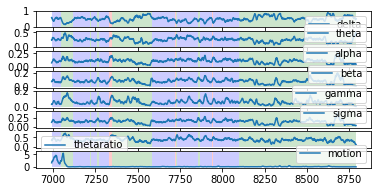

In [10]:
from matplotlib.patches import Rectangle

rcParams['figure.figsize'] = 25, 25

start_time = 3600 * 50
temp = df_RM.iloc[start_time:start_time+30*60,]

state_changes = np.where(np.diff(temp.label) != 0)[0]
state_changes = np.append(state_changes, len(temp)-1)

for ind, column in enumerate(wave_df.columns.values):
    plt.subplot(11, 1, ind+1)
    plt.gca().plot(temp.index.values, temp[column])
    plt.gca().legend([column])
    prev_time = 0
    for time in state_changes:
        col = 'green' if temp.label.iloc[time] == 1 else 'blue' if temp.label.iloc[time] == 2 else 'red'
        plt.gca().add_patch(Rectangle( (prev_time+temp.index.values[0], 0), time-prev_time, temp[column].max()*1.1, facecolor=col, fill=True, alpha=0.2))
        prev_time = time

## Manipulation: to Time Series

In [12]:
epoch = [num // 10 for num in range(len(df_RM))]
df_RM['epoch'] = epoch

In [13]:
good_epoch = np.where(df_RM.groupby('epoch')['label'].apply(lambda x: np.all(x.iloc[0]==x)))[0]
df_RM_r = df_RM[[True if epoch in good_epoch else False for epoch in df_RM.epoch]]
X_raw = df_RM_r.drop(columns=['Geno', 'animal']).set_index('epoch')

In [14]:
# stratified sampling
means = X_raw.groupby('epoch').mean()

X_index = means.groupby('label').sample(3000, replace=True).index

means = means
stds =  X_raw.groupby('epoch').std()
medians = X_raw.groupby('epoch').median()

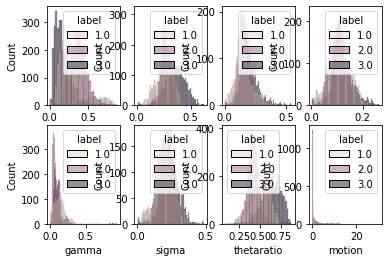

In [15]:
for ind, column in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma', 'thetaratio', 'motion']):
    plt.subplot(2, 4, ind+1)
    sns.histplot(
        data = means.loc[X_index].reset_index(),
        x = column,
        hue = 'label'
    )

<AxesSubplot:xlabel='thetaratio', ylabel='delta'>

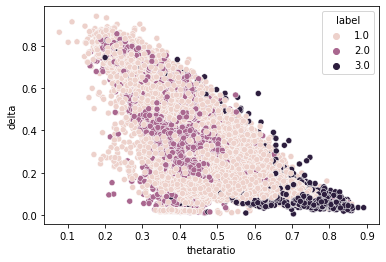

In [16]:
sns.scatterplot(
    data = means.reset_index(),
    x = 'thetaratio',
    y = 'delta',
    hue = 'label'
)

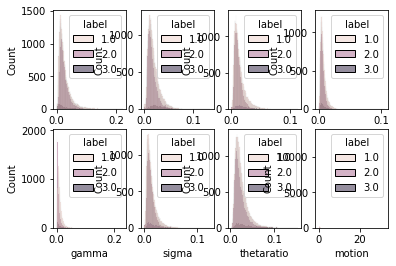

In [17]:
stds.loc[:, 'label'] = means.label.values
for ind, column in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma', 'thetaratio', 'motion']):
    plt.subplot(2, 4, ind+1)
    sns.histplot(
        data = stds.reset_index(),
        x = column,
        hue = 'label'
    )

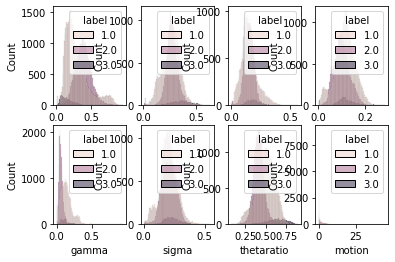

In [18]:
for ind, column in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma', 'sigma', 'thetaratio', 'motion']):
    plt.subplot(2, 4, ind+1)
    sns.histplot(
        data = medians.reset_index(),
        x = column,
        hue = 'label'
    )

In [22]:
from collections import Counter
Counter(means.label)

Counter({1.0: 39282, 2.0: 27357, 3.0: 2769})

## Model Building

In [23]:
X = pd.concat(
        [
            medians.drop(columns=['label']),
            stds.drop(columns=['label'])
        ],
        axis=1
    ).values

y = means.label

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

model_tree = GradientBoostingClassifier()
model_tree2 = AdaBoostClassifier()
for model in [model_tree, model_tree2]:
    print(
        cross_val_score(model, X, y)
    )

[0.75911252 0.77279931 0.78410892 0.77696131 0.87068655]
[0.76768477 0.74751477 0.7794266  0.75938333 0.84907427]


In [26]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

index = np.random.choice(range(len(X)), int(len(X)*0.8))
mask = np.zeros(len(X), dtype=bool)
mask[index] = True

enc = SMOTE()

X_train, y_train = enc.fit_resample(X[mask], y[mask])

X_test = X[~mask]
y_test = y[~mask]

In [27]:
model_tree.fit(X_train, y_train)

GradientBoostingClassifier()

In [28]:
model_tree.score(X_test, y_test)

0.8070506868175851

In [29]:
y_inter = model_tree.predict(X_test)
D_inter = pd.DataFrame({
    'y_inter' : y_inter,
    'epoch': y_test.index.values 
})

In [44]:
from sklearn.neighbors import KNeighborsClassifier

model_smooth = KNeighborsClassifier(n_neighbors=4)
model_smooth.fit( D_inter[['epoch']].values, D_inter['y_inter'])


KNeighborsClassifier(n_neighbors=4)

In [45]:
y_hat = model_smooth.predict(D_inter[['epoch']].values)
np.mean(
    y_hat == y_test
)

0.8326342416189043

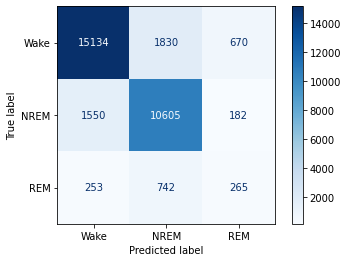

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_hat)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wake','NREM','REM'])
dis.plot(cmap=plt.cm.Blues)

todo:
- pipeline
- cross_val_score